# Model Distillation with Pytorch

## 1. Loading our SST-2 part of the GLUE dataset

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "sst2", split=["train[:60000]", "validation", "train[60000:62000]"])
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Found cached dataset glue (C:/Users/abhin/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
raw_datasets

[Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 60000
 }),
 Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 872
 }),
 Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 2000
 })]

In [3]:
from datasets import DatasetDict

In [4]:
raw_datasets = DatasetDict({
    "train": raw_datasets[0],
    "validation": raw_datasets[1],
    "test": raw_datasets[2]
})

In [5]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 60000
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 2000
    })
})

In [6]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [7]:
raw_train_dataset[5]['sentence']

"that 's far too tragic to merit such superficial treatment "

In [8]:
raw_train_dataset[5]['label']

0

In [9]:
raw_train_dataset[5]['idx']

5

In [10]:
raw_train_dataset.features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None)}

## 2. Preprocess

In [11]:
def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-ae00950b25f6f796.arrow
Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-2b780afb850e6580.arrow
Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-554ddd93b390b0c9.arrow


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60000
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## 3. Preparing for Training

In [12]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=64, collate_fn=data_collator
)

val_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=20, collate_fn=data_collator
)

eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=128, collate_fn=data_collator
)

In [15]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([64]),
 'input_ids': torch.Size([64, 36]),
 'token_type_ids': torch.Size([64, 36]),
 'attention_mask': torch.Size([64, 36])}

## 4. Loading  Model 

In [16]:
# id2label, label2id dicts for the outputs for the model
labels = tokenized_datasets["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [17]:
from transformers import AutoModelForSequenceClassification

# teacher model
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.8271, grad_fn=<NllLossBackward0>) torch.Size([64, 2])


In [19]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [20]:
from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer          = optimizer,
    num_warmup_steps   = 0,
    num_training_steps = num_training_steps,
)
print(num_training_steps)

9380


## 5. Training Loop

In [21]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [22]:
import evaluate

def eval_loop(model, dataloader):
    metric = evaluate.load("glue", "sst2")
    model.eval()
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        model_loss = outputs.loss
        logits     = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
        
    return metric.compute(), float(model_loss)

In [23]:
class EarlyStopping():
    def __init__(self, patience = 3, threshold = 0.1):
        self.patience      = patience
        self.threshold     = threshold
        self.prev_val_loss = None
        self.patienceCount = 0
        
    def _checkPatience(self,):
        if self.patienceCount == self.patience:
            return True
        else:
            self.patienceCount += 1
            return False
    
    def checkCondition(self, val_loss):
        if self.prev_val_loss == None:
            self.prev_val_loss = val_loss
        elif val_loss - self.prev_val_loss > self.threshold:
            return self._checkPatience()
        
        self.patienceCount = 0
        return False

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import time

progress_bar = tqdm(range(num_training_steps))
temperature = 4
alpha = 0.5
n_batches = len(train_dataloader)
path = './teacher-best_weight/'

train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

time_per_epoch_hist = []

model.train()
train_start = time.time() 
for epoch in range(num_epochs):
    start = time.time()
    accuracy_metric = evaluate.load("accuracy")
    
    total_loss = 0
    val_old_loss = float("Inf")
    
    earlyStopping = EarlyStopping()
    
    for b, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs    = model(**batch)
        loss       = outputs.loss
        total_loss += float(loss)
        loss.backward()
        
        logits  = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
    #### training loss and accuracy 
    avg_train_loss = total_loss / n_batches
    train_acc      = accuracy_metric.compute()
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc['accuracy'])
    
    #### validation training loss and accuracy 
    val_acc, val_loss = eval_loop(model, val_dataloader)
    val_losses.append(val_loss)
    val_accs.append(val_acc['accuracy'])
    
    if val_loss < val_old_loss:
        val_old_loss = val_loss
        saveObject = {
            'epoch': epoch + 1,
            'batch': b + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'train_acc': train_acc['accuracy'],
            'val_loss': val_loss,
            'val_acc': val_acc['accuracy']
        }
        torch.save(saveObject, path + 'bert-base-uncased-SST-2.pt')   
    
    #### Display metrics
    print("<-----------------", "Epoch", epoch + 1, "----------------->")
    print(f"Loss: {round(avg_train_loss, 2)}, Accuracy: {train_acc['accuracy']}")
    print(f"Validation Loss: {round(val_loss, 2)}, Validation Accuracy: {val_acc['accuracy']}")
    
    total_time_per_epoch = time.time() - start
    print("Elapsed Time:", round(total_time_per_epoch, 4), "sec") 
    time_per_epoch_hist.append(total_time_per_epoch)
    
    #### Check early stopping
    if earlyStopping.checkCondition(val_loss):
        print(">>>>> Early stoppping callback <<<<<")
        break

total_train_time = time.time() - train_start
print("Total Training Time:", total_train_time, "sec")

  0%|          | 0/9380 [00:00<?, ?it/s]

<----------------- Epoch 1 ----------------->
Loss: 0.21, Accuracy: 0.9178166666666666
Validation Loss: 0.3, Validation Accuracy: 0.9151376146788991
Elapsed Time: 363.6235 sec
<----------------- Epoch 2 ----------------->
Loss: 0.1, Accuracy: 0.9675166666666667
Validation Loss: 0.23, Validation Accuracy: 0.9128440366972477
Elapsed Time: 406.4118 sec
<----------------- Epoch 3 ----------------->
Loss: 0.05, Accuracy: 0.9827
Validation Loss: 0.15, Validation Accuracy: 0.9185779816513762
Elapsed Time: 401.8777 sec
<----------------- Epoch 4 ----------------->
Loss: 0.03, Accuracy: 0.98885
Validation Loss: 0.15, Validation Accuracy: 0.908256880733945
Elapsed Time: 399.8787 sec
<----------------- Epoch 5 ----------------->
Loss: 0.02, Accuracy: 0.9926666666666667
Validation Loss: 0.33, Validation Accuracy: 0.9162844036697247
Elapsed Time: 401.2774 sec
<----------------- Epoch 6 ----------------->
Loss: 0.01, Accuracy: 0.9946166666666667
Validation Loss: 0.23, Validation Accuracy: 0.91169724

In [25]:
saveMetricObject = {
    "train_losses": train_losses,
    "train_accs": train_accs,
    "val_losses": val_losses,
    "val_accs": val_accs,
    "time_per_epoch_hist": time_per_epoch_hist,
    "total_train_time": total_train_time
}

torch.save(saveMetricObject, path +  'bert-base-uncased-SST-2_training_hist.pt')

### Plotting Loss

In [26]:
import matplotlib.pyplot as plt

In [27]:
def plotLoss(trainingLoss, valLoss):
    plt.plot(trainingLoss)
    plt.plot(valLoss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Val Loss"])

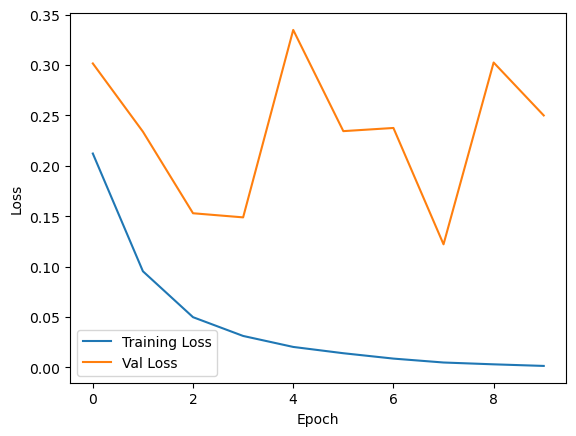

In [28]:
plotLoss(train_losses, val_losses)

### Plotting Acccuracy

In [29]:
def plotAccuracy(trainingAcc, valAcc):
    plt.plot(trainingAcc)
    plt.plot(valAcc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(["Training Accuracy", "Val Accuracy"])

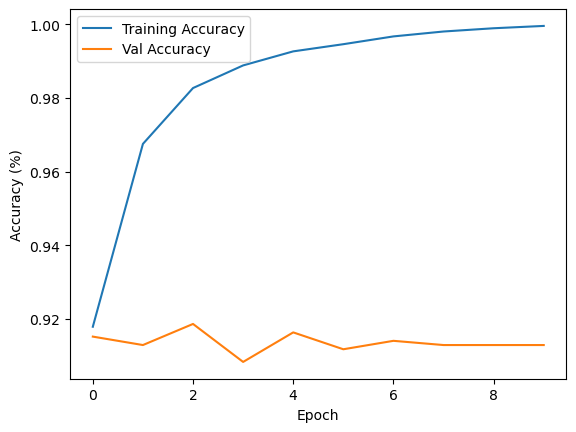

In [30]:
plotAccuracy(train_accs, val_accs)

## 6. Evaluation

In [31]:
best_weight = torch.load(path + 'bert-base-uncased-SST-2.pt')

In [32]:
model.load_state_dict(best_weight['model_state_dict'])

<All keys matched successfully>

In [33]:
eval_loop(model, eval_dataloader)[0]['accuracy']

0.9535